#### Primissimo passo: ecco in azione l'*Istituto Centrale di Statistica*

use it also in [Notebook viewer](https://nbviewer.org/github/terna/ejmmp/blob/main/model0/model0.ipynb)

if the content is missing to update, follow once [Notebook viewer and flush cache](https://nbviewer.org/github/terna/ejmmp/blob/main/model0/model0.ipynb?flush_cache=true)

In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import random as r
import matplotlib.pyplot as plt
import commonVar as cmv
import numpy as np
from tools import *

### stock-flow *model0*, the real part

- We are considering here uniquely the real part of the economy.

  

- No loans, credits, debts, capital stock, interest rate.



- Enterpreneurs have unlimited funds that they put freely in their activities.

  

- Saving is abstension from consuming.



- Investments are uniquely replacement ones, without technical progress.

### symbol table

[symbol table](https://www.caam.rice.edu/~heinken/latex/symbols.pdf) in $\LaTeX$ 

$\mathcal{N}$ - number of agents, `agentNum`

$\mathcal{N}^E$ - employer number, a uniformly distributed integer number in range $[\mathcal{E}_{min},\mathcal{E}_{max}]$, `employerNum`

$p$ - price `price`

$u$ - unemployment rate `unemploymentRate`

$dimensional~heterogeneity$ is a $true/false$ chooser, forcing increasing firms to attract more workers. `dimensionalHeterogeneity`

$\pi_{i,t}$ - labor productivity, a uniformly distributed decimal number in range $[\pi_{min},\pi_{max}]$,`productivity`

&Delta;$\pi_{i,t}$ - uniperiodal additive productivity correction in range $[$&Delta;$\pi_{min},$ &Delta;$\pi_{max}]$, `productivityDelta`

$n_{i,t}$ - number of workers in a firm, set just in time

$q_{i,t}$ - production in quantity, `production`

$\Pi_{i,t}$ - profit, `profit`

$W$ - wage `wage`

$R_{i,t}$ - revenues, `revenues`

$s_{i,t}$ - sales in quantity, `sales`

$v_{i,t}$ - in**v**entories (final, initial), `initialInventories`, `finalInventories`

$d_{i}$ - deperibility share of the production, `deperibilityShare`, setting $d_{max}$

$c_{i,t}$ - consumption rate, a uniformly distributed decimal number in range $[c_{min},c_{max}]$,`consumptionRate`

$C_{i,t}$ - consumption of $i$ in $t$

$I_{i,t}$  - investment plan  of $i$ in $t$, a uniformly distributed realization in range $[I_{min},I_{max}]$,`investmentProgram`

the investment and consumption actions are repeated in each cycle, looking around randomly for the sellers; currently `nOfConsumptionActions` $=30$ and `nOfInvestmentActions`$=10$; each consumption buy action is at maximum the 20% of the planned consumptions in that cycle; instead, each investment buy action can reach the whole amount of the investment program of the cycle; each buy action is limited by the residual capabilty of the seller

**magically**, the same good can be a consumption item or an investment one

$T$ - number of cycles `ncycles`

$t$ - cycle `cycle`


### model parameters

In [3]:
cmv.agentNum=100
employerMin=5
employerMax=20

cmv.price=1

cmv.unemploymentRate=0
cmv.dimensionalHeterogeneity=True

cmv.productivityMin=0.8
cmv.productivityMax=1.2
cmv.productivityDeltaMin=cmv.productivityMin-1
cmv.productivityDeltaMax=cmv.productivityMax-1

cmv.maxDeperibilityShare=0.5

cmv.wage=1
cmv.consumptionRateMin=0.5
cmv.consumptionRateMax=1

cmv.investmentMin=1
cmv.investmentMax=10

cmv.nOfConsumptionActions=30
cmv.nOfInvestmentActions=10
cmv.ncycles=100
cmv.cycle=0

### agent structure

The structure of a generic agent: it can represent and employer, a worker, an unemployed person.

When an agent is created, the **initialization process** defines:

- its numerical id, `num`

- its employer status, `employer`, set to $false$
- the id of its employer, `myEmployer`, set to $0$
- $R_{i,0}$ - `revenues`, initial value  $0$
- $s_{i,0}$ - `sales`, initial value  $0$
- $v^i_{i,0}$ - inventories, `initialInventories`, set to $0$ 
- $v^f_{i,0}$ - inventories, `finalInventories`, set to $0$ 
- $d_{i}$ - deperibility share, a uniformly distributed decimal number in range $[0,d_{max}]$,`deperibilityShare`
- $c_{i,0}$ - consumption rate, set to $0$
- $I_{i,0}$  - investment plan, set to $0$
- $\Pi_{i,0}$ - profit, set to 0


- $\pi_{i,t-1}$ is set after the initialization step, if an agent becomes an employer





we have also a *wallet*, currently unused



each agent has the **functions**:



- **produce** function, used only if is an employer, with:

  $\pi_{i,t}=\pi_{i,t-1}+\Delta\pi_{i,t}$

  $q_{i,t}=n_{i,t} \pi_{i,t}$

  

- **payWages**

  if employer, pays $W$ to each employee in each time $t$

  

- **buyConsumptionGoods** 

  $C_{i,t}=c_{i,t} (W+\Pi_{i,t-1})$ 	using $\Pi_{i,t-1}$ we introduce a lag with a (possible) cyclical effect

  

- **buyInvestmentGoods**

  $I_[i,t]$

  

- **makeBalanceSheet**

  $v^f_{i,t}=v^i_{i,t}+q_{i,t}-s_{i,t}-(q_{i,t}-s_{i,t}) d_{i}$

  $R_{i,t}=p s_{i,t}$

  $\Pi_{i,t}=R_{i,t}-W n_{i,t}-p(v^f_{i,t}-v^i_{i,t})$



In [4]:
class Agent():
    def __init__(self, num):
        self.num=num
        self.employer=False
        self.myEmployer=0
        self.revenues=0 #sales*price
        self.sales=0
        self.initialInventories=0
        self.finalInventories=0
        self.deperibilityShare=r.uniform(0,cmv.maxDeperibilityShare)
        self.consumptionRate=0
        self.investmentProgram=0
        self.profit=0
        self.wallet=0

    def produce(self):
        self.initialInventories=self.finalInventories
        self.productivity+=r.uniform(cmv.productivityDeltaMin,cmv.productivityDeltaMax)
        self.productivity=max(self.productivity,0)
        
        self.production=len(self.myWorkers)*self.productivity
        self.sales=0
    
    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.wallet+=cmv.wage
            
    def buyConsumptionGoods(self,k):
        if k==0: 
            self.consumptionRate=r.uniform(cmv.consumptionRateMin,cmv.consumptionRateMax)
            self.consumption=(cmv.wage+self.profit)*self.consumptionRate
            if self.consumption < 0: self.consumption=0
            self.madeConsumption=0
                
        r.shuffle(cmv.employerList)
        mySeller=cmv.employerList[0]
        self.purchase=r.uniform(0,1/5)*self.consumption 
                            # mean value 0.10 (10 buy action could be sufficient)
        self.purchase=min(self.purchase,mySeller.production+mySeller.initialInventories\
                          -mySeller.sales)
        mySeller.sales+=self.purchase/cmp.price
        self.consumption-=self.purchase
        self.madeConsumption+=self.purchase
    
    def buyInvestmentGoods(self,k):
        if k==0: 
            self.investmentProgram=r.uniform(cmv.investmentMin,cmv.investmentMax)
            self.madeInvestment=0
                       
        r.shuffle(cmv.employerList)
        mySeller=cmv.employerList[0]
        self.myInvestment=min(self.investmentProgram,mySeller.production+\
                              mySeller.initialInventories-mySeller.sales)
        mySeller.sales+=self.myInvestment/cmv.price
        self.investmentProgram-=self.myInvestment
        self.madeInvestment+=self.myInvestment
        
        
    def makeBalanceSheet(self):
        self.lostProduction=0
        if self.production - self.sales > 0: 
            self.lostProduction=(self.production - self.sales)*self.deperibilityShare
        #print(self.num, lostProduction,self.productivity)
        self.finalInventories=self.initialInventories+self.production-\
                              self.sales-self.lostProduction
        self.revenues=self.sales*cmv.price
        self.profit=self.revenues - len(self.myWorkers)*cmv.wage + \
          (self.finalInventories-self.initialInventories)*cmv.price
        #print(self.num,self.profit,self.revenues,len(self.myWorkers)*cmv.wage,\
        #      self.finalInventories, self.initialInventories)
        self.wallet+=self.profit
        


### agent setup

- agent basic creation

  

- creation of employer list

  

- selecting employers

  

- with a given (heterogeneous) productivity

  

- assigning to the employer itself as employee

  

- creation of a temporary workforce list of to-be-employed agent, escluding employers (already self employed)

  

- applying the unmployement rate to exclude agents

  

- assigning workforce (to-be-employed agents) to employers, with a reinforcement mechanism, gradually giving more attraction/hiring capacity to those who grow the most

In [5]:
def setup():
    cmv.employerNum=r.randint(employerMin, employerMax)
    cmv.agentList=[]
    for n in range(cmv.agentNum):
        anAgent=Agent(n+1)
        cmv.agentList.append(anAgent)
    

    # creation of employer list
    cmv.employerList=[]
    employerCandidates=cmv.agentList.copy()

    for n in range(cmv.employerNum):
        i=r.randint(0,len(employerCandidates))
        employerCandidates[i].employer=True
        employerCandidates[i].myEmployer=employerCandidates[i]
        employerCandidates[i].myWorkers=[employerCandidates[i]]
        employerCandidates[i].productivity=r.uniform(cmv.productivityMin,cmv.productivityMax)
        cmv.employerList.append(employerCandidates.pop(i))
    

    # creation of workforce list
    toBeEmployed=[]

    for anAgent in cmv.agentList:
        if not anAgent.employer: toBeEmployed.append(anAgent)
    for k in range(round(cmv.unemploymentRate*cmv.agentNum)):
        toBeEmployed.pop(r.randint(0,len(toBeEmployed)))
    #len(toBeEmployed)


    # assigning workforce to employers
    tmpEmployerListWithDuplications=[]
    for anAgent in cmv.agentList:
        if anAgent.employer: tmpEmployerListWithDuplications.append(anAgent)
    for anAgent in toBeEmployed:
        choice=r.choice(tmpEmployerListWithDuplications)
        anAgent.myEmployer=choice
        choice.myWorkers.append(anAgent)
        if cmv.dimensionalHeterogeneity: tmpEmployerListWithDuplications.append(choice)
            
    cmv.totalProductionSeries=[]
    cmv.totalProductionInfraVarSeries=[]
    cmv.totalProfitSeries=[]
    cmv.totalProfitInfraVarSeries=[]
    cmv.totalInitialInventoriesSeries=[]
    cmv.totalInitialInventoriesInfraVarSeries=[]
    cmv.totalFinalInventoriesSeries=[]
    cmv.totalFinalInventoriesInfraVarSeries=[]
    cmv.totalConsumptionSeries=[]
    cmv.totalConsumptionInfraVarSeries=[]
    cmv.totalInvestmentSeries=[]
    cmv.totalInvestmentInfraVarSeries=[]

    cmv.totalLostProductionSeries=[]


### meta actions



- *produceAll* orders to the employers to produce and to collects the results

  

- *payWagesAll* orders to the employers to pay wages, also to themselves

  

- *buyConsumptionGoodsAll* orders to the agents to buy investment goodsorder to the employers to buy investment goods

  

- *buyInvestmentGoodsAll* orders to the employers to buy investment goodsorder to the employers to buy investment goods



- *makeBalanceSheetAll* with everyone making accounts

In [6]:
def produceAll():
    cmv.totalProductionSeries.append(0)
    cmv.totalProductionInfraVarSeries.append(0)
    cmv.totalInitialInventoriesSeries.append(0)
    cmv.totalInitialInventoriesInfraVarSeries.append(0)
    for anAgent in cmv.agentList:
        if anAgent.employer: 
            anAgent.produce()
            cmv.totalProductionSeries[-1]+=anAgent.production
            cmv.totalProductionInfraVarSeries[-1]+=anAgent.production**2
            cmv.totalInitialInventoriesSeries[-1]+=anAgent.initialInventories
            cmv.totalInitialInventoriesInfraVarSeries[-1]+=anAgent.initialInventories**2

    cmv.totalProductionInfraVarSeries[-1]=\
                            (cmv.totalProductionInfraVarSeries[-1]/cmv.employerNum - \
                            (cmv.totalProductionSeries[-1]/cmv.employerNum)**2)
    cmv.totalInitialInventoriesInfraVarSeries[-1]=\
                            (cmv.totalInitialInventoriesInfraVarSeries[-1]/cmv.employerNum - \
                            (cmv.totalInitialInventoriesSeries[-1]/cmv.employerNum)**2)
                                          

In [7]:
def payWagesAll():
    for anAgent in cmv.agentList:
        if anAgent.employer:
            anAgent.payWages()


In [8]:
def buyConsumptionGoodsAll():
    cmv.totalConsumptionSeries.append(0)
    cmv.totalConsumptionInfraVarSeries.append(0)
    for k in range(cmv.nOfConsumptionActions):
        r.shuffle(cmv.agentList)
        for anAgent in cmv.agentList:
            anAgent.buyConsumptionGoods(k)
            if k==cmv.nOfConsumptionActions-1:
                cmv.totalConsumptionSeries[-1]+=anAgent.madeConsumption
                cmv.totalConsumptionInfraVarSeries[-1]+=anAgent.madeConsumption**2
    cmv.totalConsumptionInfraVarSeries[-1]=\
                              (cmv.totalConsumptionInfraVarSeries[-1]/cmv.agentNum - \
                              (cmv.totalConsumptionSeries[-1]/cmv.agentNum)**2)
                

In [9]:
def buyInvestmentGoodsAll():
    cmv.totalInvestmentSeries.append(0)
    cmv.totalInvestmentInfraVarSeries.append(0)
    for k in range(cmv.nOfInvestmentActions):
        for anAgent in cmv.agentList:
            if anAgent.employer:
                anAgent.buyInvestmentGoods(k)
                if k==cmv.nOfInvestmentActions-1:
                    cmv.totalInvestmentSeries[-1]+=anAgent.madeInvestment
                    cmv.totalInvestmentInfraVarSeries[-1]+=anAgent.madeInvestment**2
    cmv.totalInvestmentInfraVarSeries[-1]=\
                              (cmv.totalInvestmentInfraVarSeries[-1]/cmv.employerNum - \
                              (cmv.totalInvestmentSeries[-1]/cmv.employerNum)**2)
                

In [10]:
def makeBalanceSheetAll():
    cmv.totalProfitSeries.append(0)
    cmv.totalProfitInfraVarSeries.append(0)
    cmv.totalFinalInventoriesSeries.append(0)
    cmv.totalFinalInventoriesInfraVarSeries.append(0)
    cmv.totalLostProductionSeries.append(0)
    for anAgent in cmv.agentList:
        if anAgent.employer:
            anAgent.makeBalanceSheet()
            cmv.totalProfitSeries[-1]+=anAgent.profit
            cmv.totalProfitInfraVarSeries[-1]+=anAgent.profit**2
            cmv.totalFinalInventoriesSeries[-1]+=anAgent.finalInventories
            cmv.totalFinalInventoriesInfraVarSeries[-1]+=anAgent.finalInventories**2
            cmv.totalLostProductionSeries[-1]+=anAgent.lostProduction

    cmv.totalProfitInfraVarSeries[-1]=(cmv.totalProfitInfraVarSeries[-1]/cmv.employerNum - \
                                          (cmv.totalProfitSeries[-1]/cmv.employerNum)**2)
    cmv.totalFinalInventoriesInfraVarSeries[-1]=\
                            (cmv.totalFinalInventoriesInfraVarSeries[-1]/cmv.employerNum - \
                            (cmv.totalFinalInventoriesSeries[-1]/cmv.employerNum)**2)
                                            

## <p style="color:red">model machine</p>

- a random seed determining the random number sequences



- a list of actions (meta ones)



- an engine excecuting the meta actions



- display tools (their code is hidden into the file `tools.py`)




-------------------------------------------
employer number 19
-------------------------------------------

-------------------------------------------
"national" accounts
-------------------------------------------

t	total	lost	initial		consum.	invest.	final
	produc.	produc.	invent.				invent.
  1	102.3	0.0	0.0	    |	64.6	37.7	0.0
  2	107.2	0.0	0.0	    |	65.3	41.9	0.0
  3	105.3	0.0	0.0	    |	69.8	35.5	0.0
  4	107.5	0.0	0.0	    |	67.5	40.0	0.0
  5	104.3	0.0	0.0	    |	67.5	36.9	0.0
  6	105.7	0.0	0.0	    |	69.7	36.0	0.0
  7	106.3	0.0	0.0	    |	67.2	39.1	0.0
  8	114.6	0.0	0.0	    |	68.2	46.4	0.0
  9	118.3	0.0	0.0	    |	71.7	46.6	0.0
 10	120.2	0.0	0.0	    |	67.9	52.3	0.0
 11	117.9	0.0	0.0	    |	75.0	42.9	0.0
 12	113.7	0.0	0.0	    |	70.6	43.1	0.0
 13	111.0	0.0	0.0	    |	71.0	40.0	0.0
 14	109.5	0.0	0.0	    |	67.9	41.5	0.0
 15	109.4	0.0	0.0	    |	68.0	41.5	0.0
 16	115.4	0.0	0.0	    |	70.6	44.8	0.0
 17	117.9	0.0	0.0	    |	73.9	43.9	0.0
 18	119.9	-0.8	0.0	    |	69.5	48.0	1.6
 19	117.9	0.0	1.6	

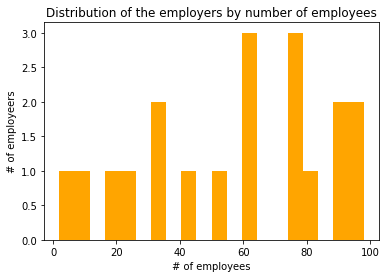

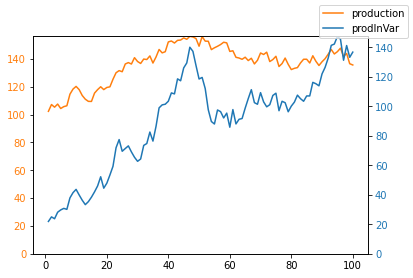

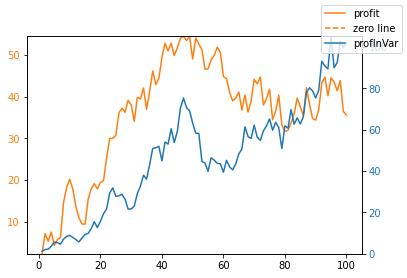

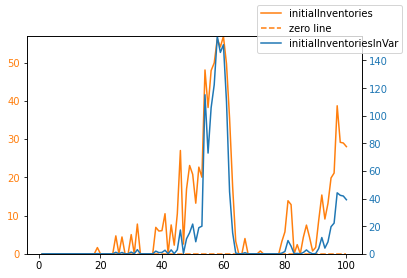

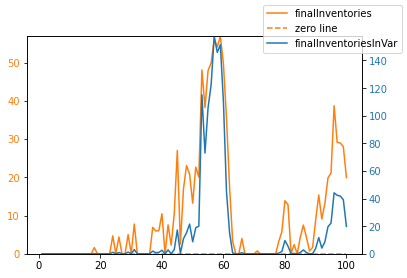

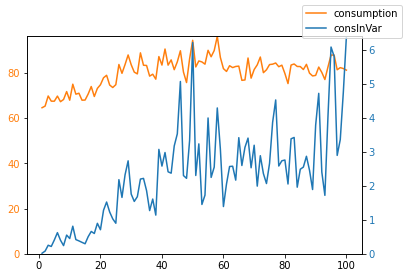

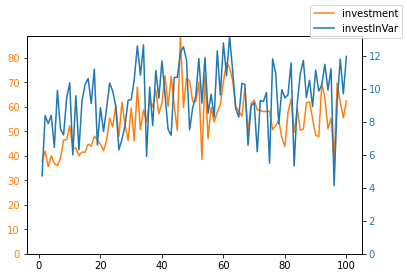

In [11]:
r.seed(121314)

setup()

cmv.actionList=["produceAll()","payWagesAll()","buyConsumptionGoodsAll()",\
                "buyInvestmentGoodsAll()","makeBalanceSheetAll()"]

for cmv.cycle in range(cmv.ncycles):
    for anAction in cmv.actionList:
            exec(anAction)

makeHist()   
plot1()
plot2()
plot3()
plot4()
plot5()
plot6()

nationalAccounts()